In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Borehole Tutorial
This is a short tutorial on using the *Parameter Space Dimension Reduction* library on the (in)famous [borehole test function](https://www.sfu.ca/~ssurjano/borehole.html).  Although this function is provided as a demo (with analytic gradients), here we provide a complete example setting up a function in this library.

## Standard imports
To begin, we import numpy and psdr.

In [2]:
import numpy as np
import psdr

## Problem Setup
To define a problem for use with this library, there are two basic steps. First we need to define the domain on which we will be working.  As engineering applications frequently have poorly scaled variables with different units, defining a domain allows us to correct this effect when evaluating the importance of a particular set of parameters.  Second, we need to define the function, posed on this domain, that we are interested in studying.  Depending on the technique we use, we need to either have access to the function itself or to samples of the function.  Here we define the function and then sample it as appropreate for each technique. 


### Defining the domain

The borehole function has eight variables:

Parameter and Domain   | Description 
---------------------|----------
$r_w \in [0.05, 0.15]$   | radius of borehole (m) 
$r \in [100, 50\times 10^3]$ | radius of influence (m) 
$T_u \in [63700, 115600]$ | transmissivity of upper aquifer ($m^2$/yr)
$H_u \in [990, 1110]$ | potentiometric head of upper aquifer (m)
$T_\ell \in [63.1, 116]	$ | transmissivity of lower aquifer ($m^2$/yr)
$H_\ell \in [700, 820]$ | potentiometric head of lower aquifer (m)
$L \in [1120, 1680]$ | length of borehole (m)
$K_w \in [9855, 12045]$ | hydraulic conductivity of borehole (m/yr)

To begin, we first setup a domain for each variable.

In [3]:
rw_domain = psdr.BoxDomain(0.05, 0.15)
r_domain = psdr.BoxDomain(100, 50e3)
Tu_domain = psdr.BoxDomain(63700, 115600)
Hu_domain = psdr.BoxDomain(990, 1110)
Tell_domain = psdr.BoxDomain(63.1, 116)
Hell_domain = psdr.BoxDomain(700, 820)
L_domain = psdr.BoxDomain(1120, 1680)
Kw_domain = psdr.BoxDomain(9855, 12045)

Then, we combine these domains for each variable into a domain for the entire borehole function:

In [4]:
borehole_domain = psdr.TensorProductDomain([
    rw_domain, r_domain, Tu_domain, Hu_domain,
    Tell_domain, Hell_domain, L_domain, Kw_domain])

This class instance provides many functions to interact with the domain.  For example, we can sample a random point in this domain.

In [5]:
borehole_domain.sample(1)

array([6.74690689e-02, 3.85446874e+04, 6.37123010e+04, 1.03155821e+03,
       7.71543910e+01, 7.23714190e+02, 1.31590499e+03, 1.10015210e+04])

### Defining the Function

The borehole function is:

$$ f(r_w, r, T_u, H_u, T_\ell, H_\ell, L, K_w) := \frac{ 2\pi T_u (H_u - H_\ell)}{\log(r/r_w) 
    ( 1 + \frac{2L T_u}{\log(r/r_w) r_w^2 K_w} + \frac{T_u}{T_\ell} )}.
$$

So we simply define this function that takes an array-like input and returns the output.

In [6]:
def borehole_func(x):
    r_w = x[0]
    r = x[1]
    T_u = x[2]
    H_u = x[3]
    T_l = x[4]
    H_l = x[5]
    L = x[6]
    K_w = x[7]
    return 2*np.pi*T_u*(H_u - H_l)/(np.log(r/r_w)*(1 + 2*L*T_u/(np.log(r/r_w)*r_w**2*K_w) + T_u/T_l))

### Wrapping the Function
For convience, we can wrap a function 

In [7]:
borehole = psdr.Function(borehole_func, borehole_domain, fd_grad = True)

## Active Subspace

In [8]:
X = borehole.sample(1000)
grads = borehole.grad(X)

In [9]:
active = psdr.ActiveSubspace()
active.fit(grads)

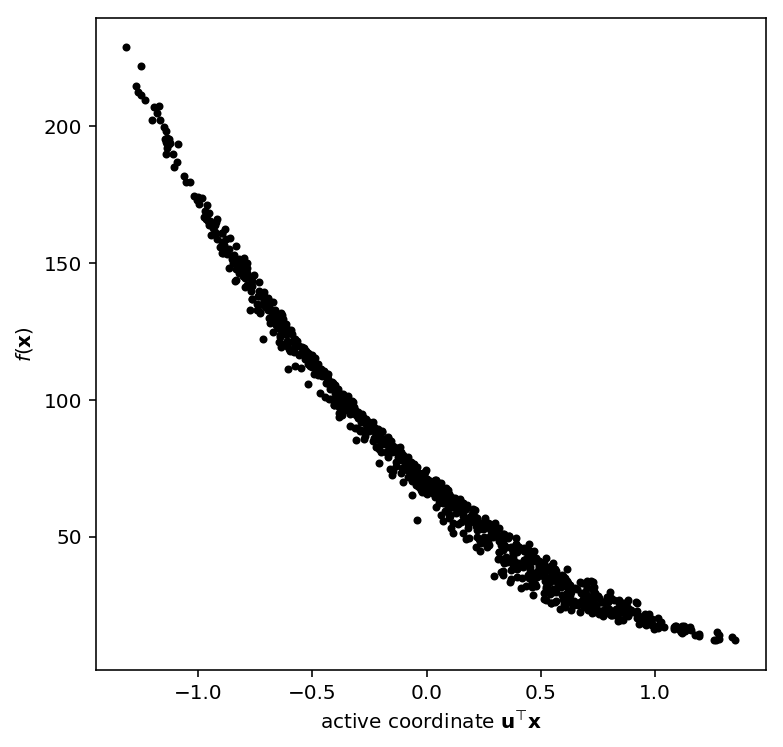

In [10]:
fX = borehole(X)
active.shadow_plot(X, fX, dim = 1)

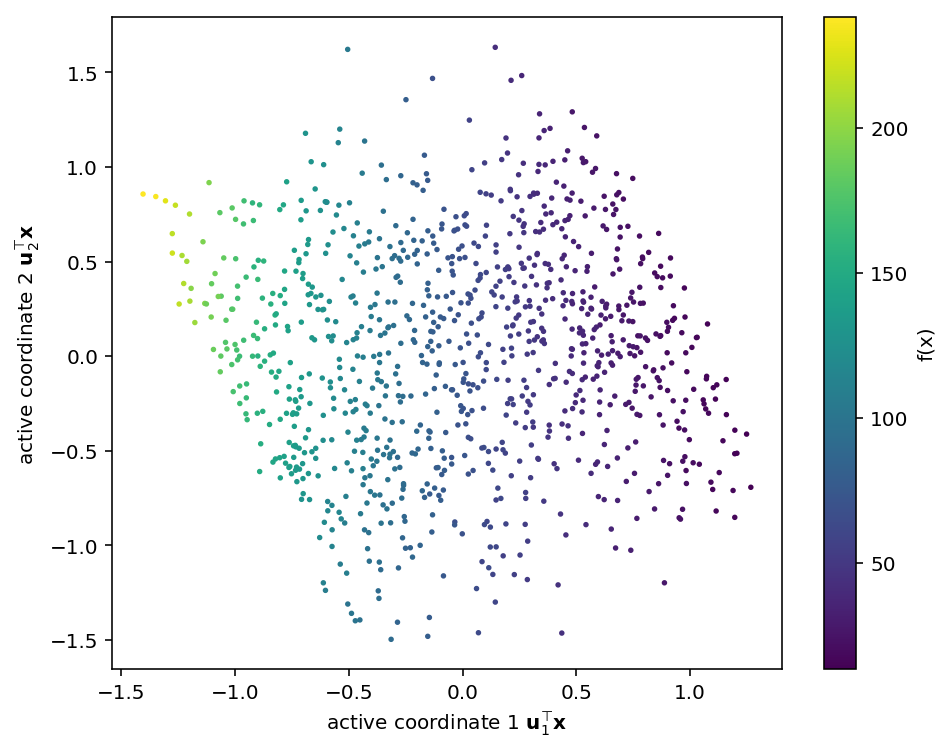

In [17]:
active.shadow_plot(X, fX, dim = 2)

## Constructing a Ridge Approximation

In [11]:
X = borehole.sample(1000)
fX = borehole(X)

In [12]:
pra = psdr.PolynomialRidgeApproximation(degree = 5, subspace_dimension = 1)
pra.fit(X, fX)

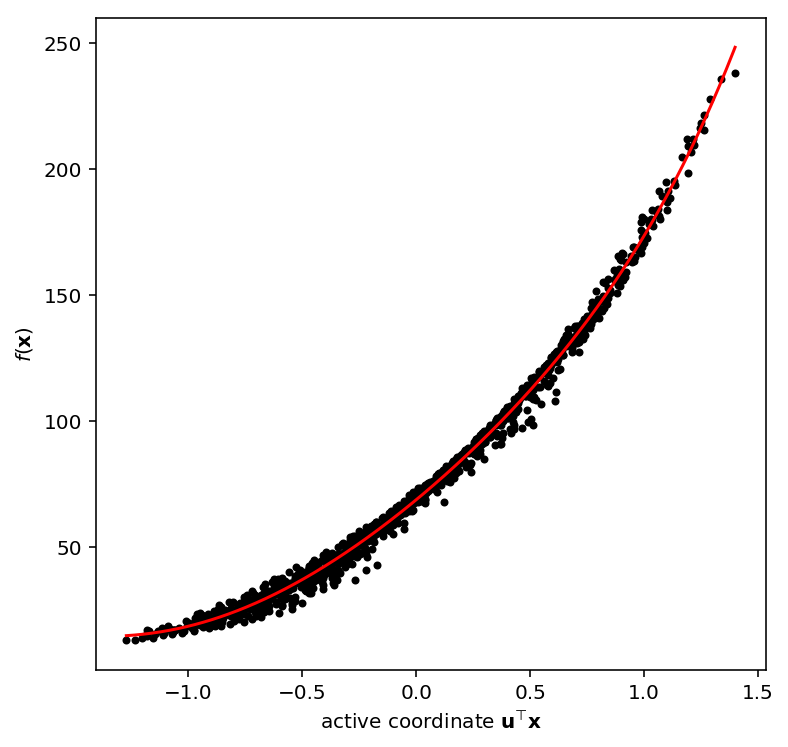

In [13]:
pra.shadow_plot(X, fX);

Of course, we can also construct ridge approximations with higher dimensional subspaces.

In [14]:
pra2 = psdr.PolynomialRidgeApproximation(degree = 5, subspace_dimension = 2)
pra2.fit(X, fX)

In [15]:
pra2.U

array([[ 0.3814528 , -0.92302795],
       [ 0.00317009, -0.00130531],
       [ 0.0203683 ,  0.00299985],
       [-0.56176444, -0.21259328],
       [-0.01853228, -0.00262655],
       [ 0.56396928,  0.2130077 ],
       [ 0.42005274,  0.21473518],
       [-0.20890299, -0.10640688]])

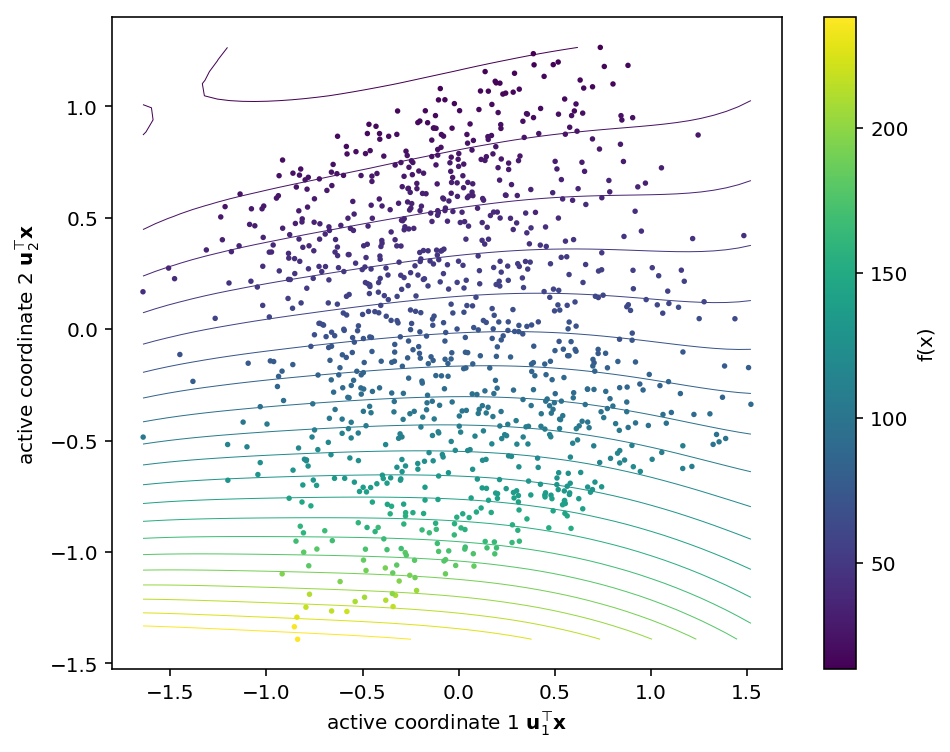

In [16]:
pra2.shadow_plot(X, fX)